# Load

In [279]:
import numpy as np
import pandas as pd
from gurobipy import *
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
from matplotlib import colors, pyplot, transforms
import copy
from matplotlib import font_manager
import seaborn as sns

fontP = font_manager.FontProperties()
fontP.set_family('SimHei')
fontP.set_size(14)

import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [2]:
distance_p2p = np.load('save/distance_p2p.npy')
distance_p2p.shape

(32, 22, 32, 22)

## mapp

In [3]:
mapp = pd.read_csv('data/map.csv', skiprows=[1])
mapp, mapp.dtypes

(     #TYPE   X   Y    NEIGHBORS
 0        1   3   0  3:1;2:0;4:0
 1        1   4   0  4:1;3:0;5:0
 2        1   5   0      5:1;4:0
 3        1   6   0          6:1
 4        5   7   0          7:1
 ..     ...  ..  ..          ...
 699      6   0  17         1:17
 700      6   0  18         1:18
 701      1   0  19         1:19
 702      1   0  20         1:20
 703      1   0  21          NaN
 
 [704 rows x 4 columns],
 #TYPE          int64
  X             int64
  Y             int64
  NEIGHBORS    object
 dtype: object)

In [4]:
mapp = mapp.astype({'#TYPE': str})

In [5]:
pos5_list = mapp.loc[mapp['#TYPE'] == '5', [' X', ' Y']].values  # 拣选, 蓝
pos5_list[:5]

array([[ 7,  0],
       [ 8,  0],
       [ 9,  0],
       [19,  0],
       [20,  0]], dtype=int64)

In [117]:
pos7_list = mapp.loc[mapp['#TYPE'] == '7', [' X', ' Y']].values  # 拣选, 蓝
pos7_list[:5]

array([[31, 20],
       [ 1,  0]], dtype=int64)

## pallets

In [161]:
pallets = pd.read_csv('data/pallets.csv')
pallets, pallets.dtypes

(                  #SKU_QUANTITY_LIST   X   Y   PALLET_ID
 0       104151:9,840211:35,1297235:1  18   8       10000
 1    901897:13,1297235:18,2171945:14  19  16       10001
 2                          653296:69  14  12       10002
 3                         1473101:66  18  15       10003
 4                961380:8,1187577:49  14   6       10004
 ..                               ...  ..  ..         ...
 143            1751060:20,2247923:14  24  15       10143
 144             582599:33,1766481:54  13   5       10144
 145             2302238:2,1867146:34  12   6       10145
 146             1286521:31,901902:24  12  13       10146
 147             1308094:52,1085002:4   9  12       10147
 
 [148 rows x 4 columns],
 #SKU_QUANTITY_LIST    object
  X                     int64
  Y                     int64
  PALLET_ID             int64
 dtype: object)

In [162]:
pallets = pallets.astype({' PALLET_ID': str})
pallets.dtypes

#SKU_QUANTITY_LIST    object
 X                     int64
 Y                     int64
 PALLET_ID            object
dtype: object

In [163]:
sku2palletID = dict()
q = dict()  # 托盘p包含商品c的数量
l = dict()  # 托盘p到最近拣选工位的距离
l_w = dict()
pallets_dict = dict()  # store the position
for i, row in pallets.iterrows():
    sku_quantity_list, x, y, pallet_id = row
    # print(sku_quantity_list, x, y, pallet_id)
    
    # process (x, y)
    temp_distance = [distance_p2p[x, y, s, t] for s, t in pos5_list]  # (x, y) → (s, t)
    idx = np.argmin(temp_distance)
    l[pallet_id] = temp_distance[idx]
    l_w[pallet_id] = idx
    pallets_dict[pallet_id] = (x, y)
    
    # process sku_quantity_list
    sku_quantity_list = sku_quantity_list.split(',')  # e.g. ['104151:9', '840211:35', '1297235:1']
    temp = dict()
    for sq_str in sku_quantity_list:  # sq_str like '104151:9'
        sku, quantity = sq_str.split(':')
        temp[sku] = int(quantity)
        
        temp2 = sku2palletID.get(sku, [])
        temp2.append((pallet_id, quantity))
        sku2palletID[sku] = temp2
    q[pallet_id] = temp
print(q['10000'])
print(min(l.values()), max(l.values()))
sku2palletID['104151'], len(sku2palletID['104151'])

{'104151': 9, '840211': 35, '1297235': 1}
5.0 20.0


([('10000', '9'), ('10027', '27')], 2)

In [164]:
l_w

{'10000': 3,
 '10001': 15,
 '10002': 15,
 '10003': 15,
 '10004': 3,
 '10005': 15,
 '10006': 17,
 '10007': 12,
 '10008': 14,
 '10009': 7,
 '10010': 9,
 '10011': 8,
 '10012': 8,
 '10013': 0,
 '10014': 0,
 '10015': 7,
 '10016': 12,
 '10017': 15,
 '10018': 0,
 '10019': 15,
 '10020': 8,
 '10021': 7,
 '10022': 3,
 '10023': 7,
 '10024': 0,
 '10025': 0,
 '10026': 9,
 '10027': 0,
 '10028': 12,
 '10029': 15,
 '10030': 2,
 '10031': 0,
 '10032': 7,
 '10033': 15,
 '10034': 5,
 '10035': 7,
 '10036': 8,
 '10037': 1,
 '10038': 14,
 '10039': 8,
 '10040': 0,
 '10041': 3,
 '10042': 15,
 '10043': 0,
 '10044': 9,
 '10045': 7,
 '10046': 0,
 '10047': 15,
 '10048': 12,
 '10049': 9,
 '10050': 8,
 '10051': 15,
 '10052': 7,
 '10053': 0,
 '10054': 8,
 '10055': 9,
 '10056': 12,
 '10057': 12,
 '10058': 2,
 '10059': 3,
 '10060': 3,
 '10061': 12,
 '10062': 12,
 '10063': 13,
 '10064': 3,
 '10065': 7,
 '10066': 3,
 '10067': 0,
 '10068': 3,
 '10069': 3,
 '10070': 4,
 '10071': 15,
 '10072': 12,
 '10073': 3,
 '10074': 5,


## orders

In [165]:
orders = pd.read_csv('data/orders.csv')
orders, orders.dtypes

(     #ORDER_ID      SKU   AMOUNT
 0            1  1579172        6
 1            2  2609314       12
 2            3  1335852       53
 3            4  1748526        5
 4            5  1332937        2
 ..         ...      ...      ...
 670        671  2201629        5
 671        672   548501       11
 672        673  2201629        1
 673        674   548501       11
 674        675   548501        2
 
 [675 rows x 3 columns],
 #ORDER_ID    int64
  SKU         int64
  AMOUNT      int64
 dtype: object)

In [166]:
orders = orders.astype({'#ORDER_ID': str, ' SKU': str})
orders.dtypes

#ORDER_ID    object
 SKU         object
 AMOUNT       int64
dtype: object

In [167]:
r = dict()  # 订单o所需商品c的数量
for i, row in orders.iterrows():
    order_id, sku, amount = row
    r[order_id] = {str(sku): amount}
r['1']

{'1579172': 6}

## agv

In [168]:
agv = pd.read_csv('data/agv.csv').astype({'#AGV_ID': str})
agv, agv.dtypes

(   #AGV_ID   X   Y
 0        1  31  14
 1        2  26  11
 2        3  29  16
 3        4   5   7
 4        5  27  18
 5        6  22  10
 6        7   9  20
 7        8  14  17
 8        9   8  11
 9       10  19  18
 10      11  25   6
 11      12   9   7
 12      13  11  16
 13      14  17   8
 14      15   0   5
 15      16   3  16
 16      17  24  15
 17      18  20   4
 18      19   4   0
 19      20   1  14,
 #AGV_ID    object
 X           int64
 Y           int64
 dtype: object)

In [169]:
agv_dict = dict()
for i, row in agv.iterrows():
    agv_id, x, y = row
    agv_dict[agv_id] = (x, y)
len(agv_dict), agv_dict['1']

(20, (31, 14))

# Model 1: Choose Pallets

In [15]:
P = pallets[' PALLET_ID'].values  # 托盘集合, np.array, dtype=int64, shape=148
O = orders['#ORDER_ID'].values  # 订单集合, np.array, dtype=int64, shape=675
C = set()  # 商品集合, set of length 181
for _ in q.values():  # _ like {'104151': 9, '840211': 35, '1297235': 1}
    for sku in _:
        C.add(sku)
# q_p^c (托盘p包含商品c的数量) is calculated when iterating through pallets.csv
# r_o^c (订单o所需商品c的数量) is calculated when iterating through orders.csv
# l_p (托盘p到最近拣选工位的距离) is calculated when iterating through pallets.csv
q[P[0]].get('1003105', 0), r[O[0]].get('1003105', 0), l[P[0]]

(0, 0, 13.0)

In [16]:
m1 = Model('choose pallets')
x = m1.addVars(P, vtype=GRB.BINARY)
m1.setObjective(x.prod(l), GRB.MINIMIZE)
for c in C:
    m1.addConstr(sum([q[_].get(c, 0) * x[_] for _ in P]) >= sum([r[_].get(c, 0) for _ in O]))

Academic license - for non-commercial use only - expires 2022-06-13
Using license file C:\Users\Carlos\gurobi.lic


In [37]:
# [print constraints Gurobi Python](https://stackoverflow.com/a/61871598/12224183)
# m.write('save/model_1.lp')
m1.display()

Minimize
   <gurobi.LinExpr: 0.0>
Subject To


In [64]:
m1.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 181 rows, 148 columns and 294 nonzeros
Model fingerprint: 0x6b696161
Variable types: 0 continuous, 148 integer (148 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [5e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+02]
Found heuristic solution: objective 1662.0000000
Presolve removed 181 rows and 148 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds
Thread count was 1 (of 12 available processors)

Solution count 2: 1655 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.655000000000e+03, best bound 1.655000000000e+03, gap 0.0000%


In [65]:
m1.objVal

1655.0

In [66]:
p_selected_idx = []
p_unselected_idx = []
for v in m1.getVars():
    if abs(v.x) > 1e-6:
        # print(v.varName, v.x)
        p_selected_idx.append(int(v.varName[1:]))
    else:
        p_unselected_idx.append(int(v.varName[1:]))
len(p_selected_idx), p_unselected_idx

(140, [69, 140, 141, 142, 143, 145, 146, 147])

In [67]:
len({list(P)[_] for _ in p_selected_idx})

140

In [68]:
[list(P)[_] for _ in [69, 140, 141, 142, 143, 145, 146, 147]]

['10069', '10140', '10141', '10142', '10143', '10145', '10146', '10147']

# Model 2: Choose Pallets

In [48]:
C_prime = set()  # 仅存在于一个托盘中的商品集合
C_prime_bar = set()  # 存在于多个托盘中的商品集合
for _ in C:
    if len(sku2palletID[_]) == 1:
        C_prime.add(_)
    elif len(sku2palletID[_]) > 1:
        C_prime_bar.add(_)
    else:
        assert False
len(C), len(C_prime), len(C_prime_bar)

(181, 126, 55)

In [49]:
P_prime = set()  # 包含C'中商品的托盘集合
for p in P:
    for c in q[p].keys():
        if c in C_prime:
            P_prime.add(p)
P_prime_bar = set(P) - P_prime
len(P_prime), len(P_prime_bar)

(97, 51)

In [51]:
m2 = Model('choose pallets')
x = m2.addVars(P_prime_bar, vtype=GRB.BINARY)
m2.setObjective(x.prod(l), GRB.MINIMIZE)
for c in C_prime_bar:
    m2.addConstr(sum([q[_].get(c, 0) for _ in P_prime]) + 
                 sum([q[_].get(c, 0) * x[_] for _ in P_prime_bar]) 
                 >= sum([r[_].get(c, 0) for _ in O]))

In [52]:
m2.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 55 rows, 51 columns and 89 nonzeros
Model fingerprint: 0x8cc60f47
Variable types: 0 continuous, 51 integer (51 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [5e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e+00, 3e+02]
Found heuristic solution: objective 506.0000000
Presolve removed 55 rows and 51 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds
Thread count was 1 (of 12 available processors)

Solution count 1: 506 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.060000000000e+02, best bound 5.060000000000e+02, gap 0.0000%


In [59]:
m2.objVal

506.0

In [58]:
# p_selected_idx = []
# p_unselected_idx = []
# for v in m2.getVars():
#     if abs(v.x) > 1e-6:
#         # print(v.varName, v.x)
#         p_selected_idx.append(int(v.varName[1:]))
#     else:
#         p_unselected_idx.append(int(v.varName[1:]))
# len(p_selected_idx), p_unselected_idx  # (43, [6, 9, 19, 27, 36, 39, 40, 47])

In [57]:
# [list(P_prime_bar)[_] for _ in [6, 9, 19, 27, 36, 39, 40, 47]]
# # ['10145', '10147', '10143', '10141', '10140', '10146', '10142', '10069']

# Model 3: Choose Fully Packed Pallets

In [92]:
comb = []
for p, d in q.items():
    for c in d.keys():
        comb.append((p, c))
comb[:3]

[('10000', '104151'), ('10000', '840211'), ('10000', '1297235')]

In [91]:
P_selected = [list(P)[_] for _ in p_selected_idx]
P_selected[:3]

['10000', '10001', '10002']

In [145]:
m3 = Model()
s = m3.addVars(comb, vtype=GRB.INTEGER)
n = m3.addVars(P_selected, vtype=GRB.BINARY) # size: 140
m3.setObjective(sum([n[_] for _ in n]), GRB.MAXIMIZE)

for c in C:
    m3.addConstr(sum([s.get((_, c), 0) for _ in P_selected]) == 
                 sum([r[_].get(c, 0) for _ in O]))
    for p in P_selected:
        m3.addConstr(s.get((p, c), 0) <= q[p].get(c, 0))
        m3.addConstr(s.get((p, c), 0) >= q[p].get(c, 0) * n[p])

In [146]:
m3.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 50861 rows, 434 columns and 1116 nonzeros
Model fingerprint: 0x2f8648d9
Variable types: 0 continuous, 434 integer (140 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+02]
Presolve removed 50861 rows and 434 columns
Presolve time: 0.01s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 12 available processors)

Solution count 1: 139 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.390000000000e+02, best bound 1.390000000000e+02, gap 0.0000%


In [164]:
s.items()[:3], s[('10000', '104151')].x

([(('10000', '104151'), <gurobi.Var C0 (value 9.0)>),
  (('10000', '840211'), <gurobi.Var C1 (value 35.0)>),
  (('10000', '1297235'), <gurobi.Var C2 (value 1.0)>)],
 9.0)

In [178]:
sum([_.x for _ in s.values()]), sum([list(_.values())[0] for _ in r.values()])

(8478.0, 8478)

# Model 4: Choose Fully Packed Pallets without Considering Distance

In [139]:
comb = []
for p, d in q.items():
    for c in d.keys():
        comb.append((p, c))
comb[:3]

[('10000', '104151'), ('10000', '840211'), ('10000', '1297235')]

In [140]:
m4 = Model()
s = m4.addVars(comb, vtype=GRB.INTEGER)
n = m4.addVars(P, vtype=GRB.BINARY) # size: 140
m4.setObjective(sum([n[_] for _ in n]), GRB.MAXIMIZE)

for c in C:
    m4.addConstr(sum([s.get((_, c), 0) for _ in P]) == 
             sum([r[_].get(c, 0) for _ in O]))
    for p in P:
        m4.addConstr(s.get((p, c), 0) <= q[p].get(c, 0))
        m4.addConstr(s.get((p, c), 0) >= q[p].get(c, 0) * n[p])

In [141]:
m4.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 53757 rows, 442 columns and 1176 nonzeros
Model fingerprint: 0xd9af3e75
Variable types: 0 continuous, 442 integer (148 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+02]
Presolve removed 53757 rows and 442 columns
Presolve time: 0.01s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds
Thread count was 1 (of 12 available processors)

Solution count 1: 140 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.400000000000e+02, best bound 1.400000000000e+02, gap 0.0000%


In [1]:
# for v in m4.getVars():
#     print(v.varName, v.x)

# Model 5

In [26]:
len(P), len(O), 148 * 675

(148, 675, 99900)

In [27]:
b_comb = []
s_comb = []
for p in P:
    for o in O:
        b_comb.append((p, o))
        s_comb.append((p, o))
b_comb[:3]

[('10000', '1'), ('10000', '2'), ('10000', '3')]

In [28]:
list(l.items())[:3]

[('10000', 13.0), ('10001', 5.0), ('10002', 16.0)]

In [29]:
M = max([sum([v for v in _.values()]) for _ in q.values()])
M

192

In [30]:
list(r['1'].values())[0]

6

In [39]:
m5 = Model()
b = m5.addVars(b_comb, vtype=GRB.BINARY)  # sizeL 99900
s = m5.addVars(s_comb, vtype=GRB.INTEGER) # size: 99900
m5.setObjective(
    sum(l[p] * b[(p, o)] for p in P for o in O), GRB.MINIMIZE
)

In [42]:
for p in tqdm(P):  # 148/148 [09:47<00:00,  3.97s/it]
    for c in C:
        m5.addConstr(
            sum(np.sign(r[_].get(c, 0)) * s[(p, _)] for _ in O) <=  
            q[p].get(c, 0)
        )
    for o in O:
        m5.addConstr(s[(p, o)] <= M * b[(p, o)])

  0%|                                                                                                  | 0/675 [00:00<?, ?it/s]


KeyError: ('1', '1')

In [44]:
for o in tqdm(O):  # [00:00<00:00, 3628.68it/s]
    m5.addConstr(sum(s[(_, o)] for _ in P) == list(r[o].values())[0])

100%|██████████████████████████████████████████████████████████████████████████████████████| 675/675 [00:00<00:00, 3628.68it/s]


In [43]:
list(r[o].values())[0]

6

In [45]:
m5.write('save/model_5.lp')

In [46]:
m5.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 127363 rows, 199800 columns and 399600 nonzeros
Model fingerprint: 0xc6e0958d
Variable types: 0 continuous, 199800 integer (99900 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [5e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 127244 rows and 199604 columns
Presolve time: 0.35s
Presolved: 119 rows, 196 columns, 392 nonzeros
Variable types: 0 continuous, 196 integer (98 binary)

Root relaxation: objective 8.430838e+03, 205 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 8430.83766    0    7          - 8430.83766      -     -    0s
H    0     0                    8480.0000000 8430.83766  0.58%     -    0s
H   

In [63]:
m5.objVal

8444.0

In [65]:
sum_s = 0
for k, v in s.items():
    if abs(v.x) > 1e-6:
        # print('varName: {}, k: {}, v: {}'.format(v.varName, k, v.x))
        sum_s += v.x
sum_s

8478.0

# Model 6

In [24]:
M = max([sum([v for v in _.values()]) for _ in q.values()])
lam = 0.994
M, lam

(192, 0.994)

In [242]:
m6 = Model()
b = m6.addVars(b_comb, vtype=GRB.BINARY)  # size: 99900, 托盘p是否运送订单o所需商品
s = m6.addVars(s_comb, vtype=GRB.INTEGER) # size: 99900, 托盘p运送订单o所需商品的数量
n = m6.addVars(P, vtype=GRB.BINARY)  # size: 148, 运送完所有订单后托盘p是否为空
m6.setObjective(
    lam * sum(l[p] * b[(p, o)] for p in P for o in O) -
    (1 - lam) * sum(n[p] for p in P), GRB.MINIMIZE
)

In [243]:
for p in tqdm(P):
    m6.addConstr(
        sum([q[p].get(_, 0) for _ in C]) - 
        sum([s[(p, _)] for _ in O]) <= M * (1 - n[p])
    )
    
for o in tqdm(O):  # [00:00<00:00, 3628.68it/s]
    m6.addConstr(sum(s[(_, o)] for _ in P) == list(r[o].values())[0])

for p in tqdm(P):  # 148/148 [09:47<00:00,  3.97s/it]
    for c in C:
        m6.addConstr(
            sum(np.sign(r[_].get(c, 0)) * s[(p, _)] for _ in O) <=  
            q[p].get(c, 0)
        )
    for o in O:
        m6.addConstr(s[(p, o)] <= M * b[(p, o)])

100%|████████████████████████████████████████████████████████████████████████████████████████| 148/148 [14:11<00:00,  5.75s/it]


In [303]:
pallets_dict

{'10000': (18, 8),
 '10001': (19, 16),
 '10002': (14, 12),
 '10003': (18, 15),
 '10004': (14, 6),
 '10005': (14, 13),
 '10006': (21, 16),
 '10007': (7, 15),
 '10008': (11, 16),
 '10009': (22, 6),
 '10010': (20, 15),
 '10011': (20, 9),
 '10012': (19, 12),
 '10013': (5, 9),
 '10014': (5, 6),
 '10015': (22, 8),
 '10016': (8, 13),
 '10017': (17, 16),
 '10018': (7, 9),
 '10019': (13, 15),
 '10020': (23, 9),
 '10021': (25, 8),
 '10022': (12, 8),
 '10023': (20, 6),
 '10024': (8, 8),
 '10025': (5, 5),
 '10026': (25, 13),
 '10027': (9, 6),
 '10028': (6, 16),
 '10029': (17, 12),
 '10030': (14, 5),
 '10031': (7, 6),
 '10032': (23, 8),
 '10033': (14, 15),
 '10034': (24, 5),
 '10035': (24, 8),
 '10036': (23, 12),
 '10037': (8, 5),
 '10038': (12, 16),
 '10039': (21, 12),
 '10040': (6, 9),
 '10041': (18, 6),
 '10042': (18, 16),
 '10043': (5, 8),
 '10044': (22, 13),
 '10045': (24, 6),
 '10046': (7, 5),
 '10047': (11, 13),
 '10048': (6, 15),
 '10049': (21, 13),
 '10050': (26, 9),
 '10051': (17, 13),
 '

In [76]:
m6.write('save/model_6.lp')

In [244]:
m6.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 127511 rows, 199948 columns and 499648 nonzeros
Model fingerprint: 0xd848b08d
Variable types: 0 continuous, 199948 integer (100048 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [6e-03, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 126929 rows and 199097 columns
Presolve time: 1.00s
Presolved: 582 rows, 851 columns, 2063 nonzeros
Variable types: 0 continuous, 851 integer (477 binary)

Root relaxation: objective 8.266438e+03, 696 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 8266.43844    0   46          - 8266.43844      -     -    1s
H    0     0                    8519.7640000 8266.43844  2.97%     -    1s
H

In [314]:
set_n = set()
for key, value in n.items():
    if abs(value.x) > 1e-6:
        pallet_id = key
        set_n.add(pallet_id)
len(set_n), pallets_dict.keys() - set_n

(134,
 {'10069',
  '10108',
  '10112',
  '10125',
  '10126',
  '10130',
  '10140',
  '10141',
  '10142',
  '10143',
  '10144',
  '10145',
  '10146',
  '10147'})

In [316]:
set_bp = set()
for key, value in b.items():
    if abs(value.x) > 1e-6:
        pallet_id, order_id = key
        if pallet_id not in set_bp:
            set_bp.add(pallet_id)
len(set_bp), pallets_dict .keys() - set_bp

(143, {'10069', '10142', '10143', '10146', '10147'})

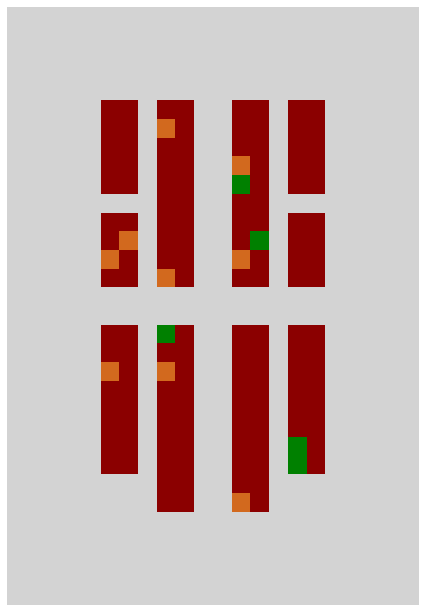

In [324]:
fig, ax = plt.subplots(figsize=(16, 11))
plt.axis('off')
# plot map
cmap = colors.ListedColormap(['lightgray', 'green', 'chocolate', 'darkred'])
bounds = [0.5, 1.5, 2.5, 3.5, 4.5]
norm = colors.BoundaryNorm(bounds, cmap.N)
temp = np.ones([32, 22])
for pallet_id in pallets_dict.keys():
    x, y = pallets_dict[pallet_id]
    temp[x, y] = 2
for pallet_id in set_bp:
    x, y = pallets_dict[pallet_id]
    temp[x, y] = 3
for pallet_id in set_n:
    x, y = pallets_dict[pallet_id]
    temp[x, y] = 4
ax.imshow(temp, cmap=cmap, norm=norm)
plt.savefig('images/question2-bn.png', bbox_inches='tight')

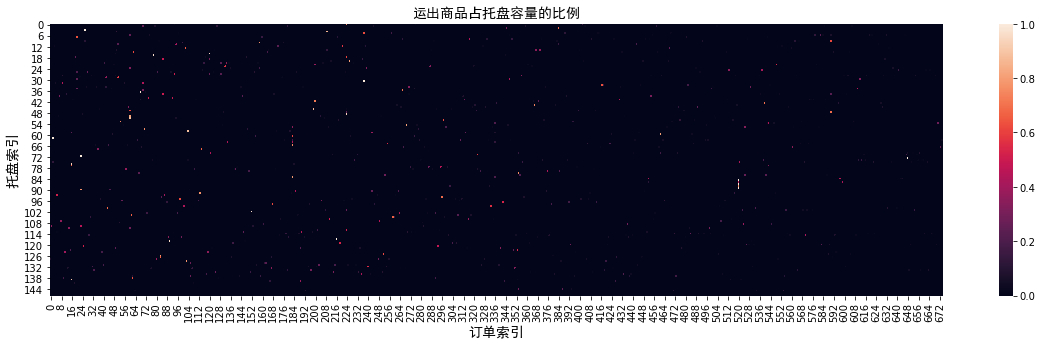

In [330]:
temp = np.zeros([148, 675])
for key, value in s.items():
    if abs(value.x) > 1e-6:
        #print('varName: {}, k: {}, v: {}'.format(v.varName, k, v.x))
        pallet_id, order_id = key
        pallet_idx = int(pallet_id) - 10000
        order_idx = int(order_id) - 1
        temp[pallet_idx, order_idx] = value.x / sum(q[pallet_id].values())
plt.rcParams['figure.figsize'] = [20, 5]
sns.heatmap(temp)
plt.title('运出商品占托盘容量的比例', fontproperties=fontP)
plt.xlabel('订单索引', fontproperties=fontP)
plt.ylabel('托盘索引', fontproperties=fontP)
plt.savefig('images/托盘p运送订单o所需商品的数量.png', bbox_inches='tight')

In [335]:
temp = np.empty([675, 148], dtype=object)
temp = {_: dict() for _ in O}
for key, value in s.items():
    if abs(value.x) > 1e-6:
        pallet_id, order_id = key
        temp[order_id][pallet_id] = value.x

In [343]:
temp['1'], temp['2'], temp['3'], temp['4'], temp['5'], temp['6'], temp['675']

({'10128': 6.0},
 {'10110': 12.0},
 {'10062': 49.0, '10075': 4.0},
 {'10012': 5.0},
 {'10032': 2.0},
 {'10093': 24.0, '10113': 1.0},
 {'10063': 2.0})

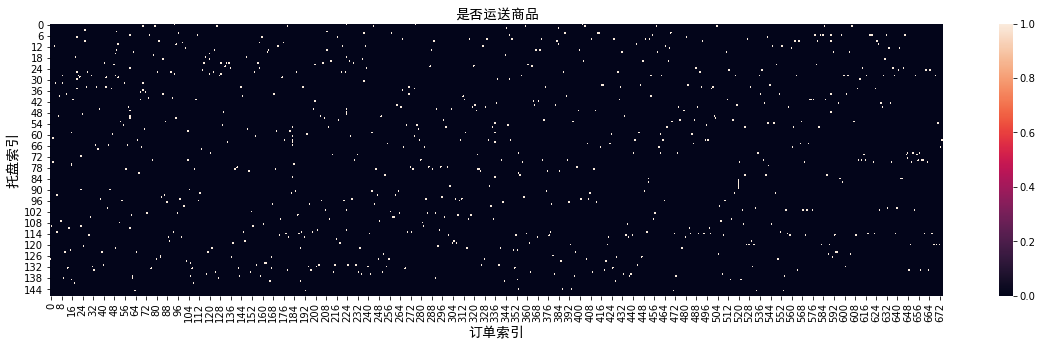

In [329]:
temp = np.zeros([148, 675])
for key, value in b.items():
    if abs(value.x) > 1e-6:
        #print('varName: {}, k: {}, v: {}'.format(v.varName, k, v.x))
        pallet_id, order_id = key
        pallet_idx = int(pallet_id) - 10000
        order_idx = int(order_id) - 1
        temp[pallet_idx, order_idx] = value.x
plt.rcParams['figure.figsize'] = [20, 5]
sns.heatmap(temp)
plt.title('是否运送商品', fontproperties=fontP)
plt.xlabel('订单索引', fontproperties=fontP)
plt.ylabel('托盘索引', fontproperties=fontP)
plt.savefig('images/托盘p是否运送订单o所需商品.png', bbox_inches='tight')

In [325]:
s

{('10000', '1'): <gurobi.Var C99900 (value 0.0)>,
 ('10000', '2'): <gurobi.Var C99901 (value 0.0)>,
 ('10000', '3'): <gurobi.Var C99902 (value 0.0)>,
 ('10000', '4'): <gurobi.Var C99903 (value 0.0)>,
 ('10000', '5'): <gurobi.Var C99904 (value 0.0)>,
 ('10000', '6'): <gurobi.Var C99905 (value 0.0)>,
 ('10000', '7'): <gurobi.Var C99906 (value 0.0)>,
 ('10000', '8'): <gurobi.Var C99907 (value 0.0)>,
 ('10000', '9'): <gurobi.Var C99908 (value 0.0)>,
 ('10000', '10'): <gurobi.Var C99909 (value 0.0)>,
 ('10000', '11'): <gurobi.Var C99910 (value 0.0)>,
 ('10000', '12'): <gurobi.Var C99911 (value 0.0)>,
 ('10000', '13'): <gurobi.Var C99912 (value 0.0)>,
 ('10000', '14'): <gurobi.Var C99913 (value 0.0)>,
 ('10000', '15'): <gurobi.Var C99914 (value 0.0)>,
 ('10000', '16'): <gurobi.Var C99915 (value 0.0)>,
 ('10000', '17'): <gurobi.Var C99916 (value 0.0)>,
 ('10000', '18'): <gurobi.Var C99917 (value 0.0)>,
 ('10000', '19'): <gurobi.Var C99918 (value 0.0)>,
 ('10000', '20'): <gurobi.Var C99919 (va

# Model 7: Question 2

In [188]:
W = [(8, 0), (20, 0), (31, 7), (31, 15), (8, 21), (20, 21)] # (x, y)
lw = dict()  # 托盘p到最近拣选工位的距离
for i, row in pallets.iterrows():
    sku_quantity_list, x, y, pallet_id = row
    temp = dict()
    for ws, wt in W:
        temp[(ws, wt)] = distance_p2p[x, y, ws, wt]
    lw[pallet_id] = temp

q_p = {k: sum(v.values()) for k, v in q.items()}
mu = sum(q_p.values()) / len(W)
mu

1477.5

In [183]:
e_comb = []
for p in P:
    for w in W:
        e_comb.append((p, w))
e_comb[:3], len(e_comb)

([('10000', (8, 0)), ('10000', (20, 0)), ('10000', (31, 7))], 888)

In [211]:
epsilons = np.linspace(0.5, 738, 1000, endpoint=True)
objVals = np.zeros(len(epsilons))

In [212]:
for i, epsilon in tqdm(enumerate(epsilons)):  # 1000it [00:46, 21.37it/s]
    L, U = mu - epsilon, mu + epsilon
    m7 = Model()
    e = m7.addVars(e_comb, vtype=GRB.BINARY)  # size: 888 
    m7.setObjective(
        sum([lw[p][w] * e[(p, w)] for p in P for w in W]), GRB.MINIMIZE
    )
    for p in P:
        m7.addConstr(sum(e[(p, w)] for w in W) == 1)
    for w in W:
        m7.addConstr(sum([q_p[p] * e[(p, w)] for p in P]) <= U)
        m7.addConstr(sum([q_p[p] * e[(p, w)] for p in P]) >= L)
    m7.Params.LogToConsole = 0
    m7.optimize()
    objVals[i] = m7.objVal

1000it [00:46, 21.37it/s]


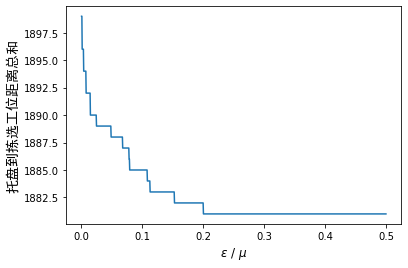

In [224]:
plt.plot([_ / mu for _ in epsilons], objVals)
plt.xlabel(r'$\epsilon$ / $\mu$', fontsize='large')
plt.ylabel('托盘到拣选工位距离总和', fontproperties=fontP)
plt.savefig('images/question2-2.png', bbox_inches='tight')

In [190]:
palletID2pos = []
for k, v in e.items():
    if abs(v.x) > 1e-6:
        #print('varName: {}, k: {}, v: {}'.format(v.varName, k, v.x))
        palletID2pos.append(k)
with open('save/palletID2pos.pickle', 'wb') as handle:
    pickle.dump(palletID2pos, handle)  # for ploting in 4 - environment.ipynb

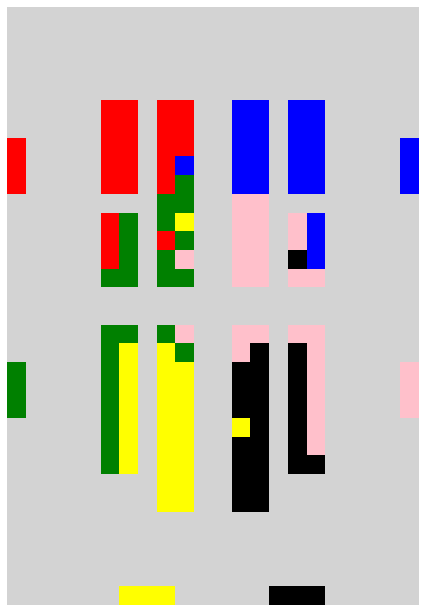

In [210]:
fig, ax = plt.subplots(figsize=(16, 11))
plt.axis('off')
# plot map
cmap = colors.ListedColormap(['lightgray', 'green', 'yellow', 'black', 'blue', 'pink', 'red'])
W2colorIdx = {(8, 0): 7, (20, 0): 2, (31, 7): 3, (31, 15): 4, (8, 21): 5, (20, 21): 6}
bounds = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]
norm = colors.BoundaryNorm(bounds, cmap.N)
question2_array = np.ones([32, 22])
for pallet_id, (wx, wy) in palletID2pos:
    x, y = pallets_dict[pallet_id]
    question2_array[x, y] = W2colorIdx[(wx, wy)]
for w3 in W3:
    for w in W:
        if w in w3:
            for (x, y) in w3:
                question2_array[x, y] = W2colorIdx[(w[0], w[1])]
ax.imshow(question2_array, cmap=cmap, norm=norm)
plt.savefig('images/question2.png', bbox_inches='tight')

# Model 8: MTSP

In [246]:
# parameters unchanged
M = max([sum([v for v in _.values()]) for _ in q.values()])  # 辅助参数
lam = 0.994  # 权系数, in (147 / 148, 1)
agv_pos = agv_dict.copy()
M, lam

(192, 0.994)

In [18]:
# parameters
max_size_O = 50
gather_num = 6  # int ge 6

In [19]:
O_seperated = []
for i in range(math.ceil(len(O) / max_size_O)):
    O_seperated.append(O[i * max_size_O: (i + 1) * max_size_O])
sum([len(_) for _ in O_seperated]), len(O)

(675, 675)

## Order in First Batch

In [20]:
k = 0 # 订单的批次序号集合, k = 0, ..., max_size_O - 1

In [21]:
Ok = O_seperated[k]  # 第k批订单集合

In [36]:
Pk = set()  # 运送第k批订单的托盘集合
for key, value in b.items():  # b is solved by model6
    if abs(value.x) > 1e-6:
        pallet_id, order_id = key
        if order_id in Ok:  # Pk is determined by Ok
            Pk.add(pallet_id)
len(Pk), list(Pk)[:5]

(52, ['10012', '10115', '10077', '10016', '10093'])

In [37]:
Gpp = []  # 执行回收任务的AGV集合
W = [(8, 0), (20, 0), (31, 7), (31, 15), (8, 21), (20, 21)] # (x, y)
assert gather_num >= 6
temp_agv_dict = agv_dict.copy()
count = 0
while count < gather_num:
    for (xw, yw) in W:
        agv_id = min(temp_agv_dict,
                     key=lambda x: distance_p2p[temp_agv_dict[x][0], 
                                               temp_agv_dict[x][1],
                                               xw, yw])
        del temp_agv_dict[agv_id]
        Gpp.append(agv_id)
        count += 1
        print(xw, yw, agv_dict[agv_id], len(temp_agv_dict), count)
        if count == gather_num:
            break
Gpp

8 0 (4, 0) 19 1
20 0 (20, 4) 18 2
31 7 (31, 14) 17 3
31 15 (29, 16) 16 4
8 21 (9, 20) 15 5
20 21 (19, 18) 14 6


['19', '18', '1', '3', '7', '10']

In [38]:
Gp = agv_dict.keys() - {'11'} - set(Gpp)
delivery_num = len(Gp)
Gp, delivery_num

({'12', '13', '14', '15', '16', '17', '2', '20', '4', '5', '6', '8', '9'}, 13)

In [39]:
lpgk = dict()
for p in Pk:
    temp = dict()
    for g in Gp:
        temp[g] = distance_p2p[agv_dict[g][0], agv_dict[g][1], pallets_dict[p][0], pallets_dict[p][1]]
    lpgk[p] = temp
len(lpgk), lpgk['10016']

(52,
 {'5': 24.0,
  '9': 12.0,
  '8': 12.0,
  '6': 19.0,
  '12': 17.0,
  '14': 18.0,
  '16': 8.0,
  '15': 18.0,
  '17': 18.0,
  '4': 13.0,
  '13': 16.0,
  '20': 8.0,
  '2': 22.0})

In [40]:
lpp = dict()
lpp_w = dict()
for p in P:
    temp = dict()
    temp_w = dict()
    for pp in P:
        temp_distance = [distance_p2p[pallets_dict[p][0],
                                      pallets_dict[p][1],
                                      x, y] +
                         distance_p2p[x, y,
                                      pallets_dict[pp][0],
                                      pallets_dict[pp][1]] for (x, y) in W]
        idx = np.argmin(temp_distance)
        temp[pp] = temp_distance[idx]
        temp_w[pp] = W[idx]
    lpp[p] = temp
    lpp_w[p] = temp_w
len(lpp)

148

In [41]:
V = ['virtual'] + list(Gp) + list(Pk)  # vertex set
len(V), V[:5]

(66, ['virtual', '5', '9', '8', '6'])

In [42]:
d = dict()  # distance matrix
A = set()  # 弧集合
for vf in V:
    temp = dict()
    for vt in V:
        A.add((vf, vt))
        if vf == 'virtual' and vt == 'virtual' or \
           vf == 'virtual' and vt in Pk or \
           vf in Gp and vt in Gp or \
           vf in Pk and vt in Gp or \
           vf == vt:
            temp[vt] = 1e6
        elif vf == 'virtual' and vt in Gp or \
             vf in Gp and vt == 'virtual':
            temp[vt] = 0
        elif vf in Gp and vt in Pk:
            temp[vt] = lpgk[vt][vf]
        elif vf in Pk and vt == 'virtual':
            temp[vt] = l[vf]
        elif vf in Pk and vt in Pk:
            assert vf != vt
            temp[vt] = lpp[vf][vt]
        else:
            assert False, 'vf: {}, vt: {}'.format(vf, vt)
    d[vf] = temp
len(d), list(A)[:5]

(66,
 [('10121', '10062'),
  ('10066', '16'),
  ('5', '15'),
  ('10105', '10100'),
  ('13', '10128')])

In [43]:
m8 = Model()
x = m8.addVars(A, vtype=GRB.BINARY)
u = m8.addVars(V, vtype=GRB.INTEGER)
m8.setObjective(
    sum(d[vf][vt] * x[(vf, vt)] for vf in V for vt in V), GRB.MINIMIZE
)
m8.addConstr(sum([x[('virtual', _)] for _ in V]) == delivery_num)
m8.addConstr(sum([x[(_, 'virtual')] for _ in V]) == delivery_num)
for v in V:
    if v != 'virtual':
        m8.addConstr(sum([x[(_, v)] for _ in V]) == 1)
        m8.addConstr(sum([x[(v, _)] for _ in V]) == 1)
for vf in V:
    for vt in V:
        if vf != 'virtual' and vt != 'virtual' and vf != vt:
            m8.addConstr(u[vf] - u[vt] + len(V) * x[(vf, vt)] <= len(V) - 1)

In [44]:
delivery_num

13

In [45]:
m8.Params.LogToConsole = 0
m8.optimize()
m8.objVal

1191.0

In [94]:
id2id = []
for key, value in x.items():
    if abs(value.x) > 1e-6:
        # print('varName: {}, key: {}, value: {}'.format(value.varName, key, value.x))
        id2id.append(key)

In [54]:
mtsp_adj_matrix = dict() 
for vf in V:
    temp = dict()
    for vt in V:
        temp[vt] = 0
    mtsp_adj_matrix[vf] = temp
for id1, id2 in id2id:
    mtsp_adj_matrix[id1][id2] = 1

In [66]:
pos2route = {_: [agv_dict[_]] for _ in Gp}
for g in Gp:
    temp_id = max(mtsp_adj_matrix[g], key=mtsp_adj_matrix[g].get)
    if temp_id == 'virtual':
        continue
    elif temp_id in Pk:
        while temp_id != 'virtual':
            pos2route[g].append(pallets_dict[temp_id])
            temp_id = max(mtsp_adj_matrix[temp_id], key=mtsp_adj_matrix[temp_id].get)
    else:
        assert False
pos2route['5'], sum([len(_) for _ in pos2route.values()]), len(V)

([(27, 18), (23, 16), (18, 15), (13, 13), (17, 12), (11, 12), (10, 13)],
 65,
 66)

## All Order

In [247]:
W3

[[(7, 0), (8, 0), (9, 0)],
 [(19, 0), (20, 0), (21, 0)],
 [(31, 6), (31, 7), (31, 8)],
 [(31, 14), (31, 15), (31, 16)],
 [(7, 21), (8, 21), (9, 21)],
 [(19, 21), (20, 21), (21, 21)]]

In [248]:
palletID2WIdx = {}
for pallet_id, (x, y) in palletID2pos:
    for widx, w in enumerate(W):
        if (x, y) == w:
            palletID2WIdx[pallet_id] = widx
            break
    else:
        assert False
list(palletID2WIdx.items())[:5]

[('10000', 2), ('10001', 5), ('10002', 5), ('10003', 3), ('10004', 1)]

In [253]:
len(O)

675

In [265]:
# parameters
max_size_O = 50
pallets_binded = False

In [266]:
max_size_O_list = [50, 100, 200, 400, 675]
total_distances = np.zeros(len(max_size_O_list))
with HiddenPrints():
    for max_size_O_idx, max_size_O in tqdm(enumerate(max_size_O_list)):
        # initialization
        batch_size = math.ceil(len(O) / max_size_O)
        O_seperated = []
        for i in range(batch_size):
            O_seperated.append(O[i * max_size_O: (i + 1) * max_size_O])
        sum([len(_) for _ in O_seperated]), len(O)
        agv_pos = copy.deepcopy(agv_dict)
        temp_q = copy.deepcopy(q)
        gather_num = 6
        W3 = [[(7, 0), (8, 0), (9, 0)],
             [(19, 0), (20, 0), (21, 0)],
             [(31, 6), (31, 7), (31, 8)],
             [(31, 14), (31, 15), (31, 16)],
             [(7, 21), (8, 21), (9, 21)],
             [(19, 21), (20, 21), (21, 21)]]  # ono-on-one to W
        total_distance = 0
        total_delivered_amount = 0

        # start
        for k in range(batch_size):  # 订单的批次序号集合, k = 0, ..., max_size_O - 1
            Ok = O_seperated[k]  # 第k批订单集合
            # print('Ok:', Ok)
            Pk = set()  # 运送第k批订单的托盘集合
            for key, value in b.items():  # b is solved by model6
                if abs(value.x) > 1e-6:
                    pallet_id, order_id = key
                    if order_id in Ok:  # Pk is determined by Ok
                        Pk.add(pallet_id)
            # print('Pk:', Pk)
            Gpp = []  # 执行回收任务的AGV集合
            temp_agv_dict = agv_pos.copy()  # update for each k
            W = [(8, 0), (20, 0), (31, 7), (31, 15), (8, 21), (20, 21)] # (x, y)
            assert gather_num >= 6
            count = 0
            while count < gather_num:
                for (xw, yw) in W:
                    agv_id = min(temp_agv_dict,
                                 key=lambda x: distance_p2p[temp_agv_dict[x][0], 
                                                           temp_agv_dict[x][1],
                                                           xw, yw])
                    del temp_agv_dict[agv_id]
                    Gpp.append(agv_id)
                    count += 1
                    if count == gather_num:
                        break
            Gp = temp_agv_dict.keys() - {'11'} - set(Gpp)
            delivery_num = len(Gp)
            lpgk = dict()
            for p in Pk:
                temp = dict()
                for g in Gp:
                    temp[g] = distance_p2p[agv_pos[g][0], agv_pos[g][1], pallets_dict[p][0], pallets_dict[p][1]]
                lpgk[p] = temp
            lpp = dict()
            lpp_w = dict()
            for p in P:
                temp = dict()
                temp_w = dict()
                for pp in P:
                    if not pallets_binded:
                        temp_distance = [distance_p2p[pallets_dict[p][0],
                                                      pallets_dict[p][1],
                                                      x, y] +
                                         distance_p2p[x, y,
                                                      pallets_dict[pp][0],
                                                      pallets_dict[pp][1]] for (x, y) in W]
                        idx = np.argmin(temp_distance)
                        temp[pp] = temp_distance[idx]
                        temp_w[pp] = W[idx]
                    else:
                        wx, wy = W[palletID2WIdx[p]]
                        temp[pp] = distance_p2p[pallets_dict[p][0], pallets_dict[p][1], wx, wy] + \
                                    distance_p2p[wx, wy, pallets_dict[pp][0], pallets_dict[pp][1]]
                        temp_w[pp] = (wx, wy)
                lpp[p] = temp
                lpp_w[p] = temp_w
            V = ['virtual'] + list(Gp) + list(Pk)  # vertex set
            d = dict()  # distance matrix
            A = set()  # 弧集合
            for vf in V:
                temp = dict()
                for vt in V:
                    A.add((vf, vt))
                    if vf == 'virtual' and vt == 'virtual' or \
                       vf == 'virtual' and vt in Pk or \
                       vf in Gp and vt in Gp or \
                       vf in Pk and vt in Gp or \
                       vf == vt:
                        temp[vt] = 1e6
                    elif vf == 'virtual' and vt in Gp or \
                         vf in Gp and vt == 'virtual':
                        temp[vt] = 0
                    elif vf in Gp and vt in Pk:
                        temp[vt] = lpgk[vt][vf]
                    elif vf in Pk and vt == 'virtual':
                        if not pallets_binded:
                            temp[vt] = l[vf]
                        else:
                            wx, wy = W[palletID2WIdx[vf]]
                            temp[vt] = distance_p2p[pallets_dict[vf][0], pallets_dict[vf][1], wx, wy]
                    elif vf in Pk and vt in Pk:
                        assert vf != vt
                        temp[vt] = lpp[vf][vt]
                    else:
                        assert False, 'vf: {}, vt: {}'.format(vf, vt)
                d[vf] = temp
            m8 = Model()
            x = m8.addVars(A, vtype=GRB.BINARY)
            u = m8.addVars(V, vtype=GRB.INTEGER)
            m8.setObjective(
                sum(d[vf][vt] * x[(vf, vt)] for vf in V for vt in V), GRB.MINIMIZE
            )
            m8.addConstr(sum([x[('virtual', _)] for _ in V]) == delivery_num)
            m8.addConstr(sum([x[(_, 'virtual')] for _ in V]) == delivery_num)
            for v in V:
                if v != 'virtual':
                    m8.addConstr(sum([x[(_, v)] for _ in V]) == 1)
                    m8.addConstr(sum([x[(v, _)] for _ in V]) == 1)
            for vf in V:
                for vt in V:
                    if vf != 'virtual' and vt != 'virtual' and vf != vt:
                        m8.addConstr(u[vf] - u[vt] + len(V) * x[(vf, vt)] <= len(V) - 1)
            m8.Params.LogToConsole = 0
            m8.optimize()
            total_distance += m8.objVal

            id2id = []
            for key, value in x.items():
                if abs(value.x) > 1e-6:
                    # print('varName: {}, key: {}, value: {}'.format(value.varName, key, value.x))
                    id2id.append(key)

            mtsp_adj_matrix = dict() 
            for vf in V:
                temp = dict()
                for vt in V:
                    temp[vt] = 0
                mtsp_adj_matrix[vf] = temp
            for id1, id2 in id2id:
                mtsp_adj_matrix[id1][id2] = 1

            # determine each m routes by solution
            pos2route = {_: [agv_dict[_]] for _ in Gp}
            for g in Gp:
                temp_id = max(mtsp_adj_matrix[g], key=mtsp_adj_matrix[g].get)
                if temp_id == 'virtual':
                    continue
                elif temp_id in Pk:
                    while temp_id != 'virtual':
                        pos2route[g].append(pallets_dict[temp_id])
                        temp_id = max(mtsp_adj_matrix[temp_id], key=mtsp_adj_matrix[temp_id].get)
                else:
                    assert False

            m8_mtsp_result = {'pos2route': pos2route, 'objVal': m8.objVal}
            # print(m8_mtsp_result)
            with open('save/m8-mtsp-bs{}-b{}.pickle'.format(batch_size, k), 'wb') as handle:
                pickle.dump(m8_mtsp_result, handle)  # for ploting

            # update
            for g in Gp:  # update agv_pos for delivery agvs
                print('k: {}, agv {} position: {} → {}'.format(k, g, agv_pos[g], pos2route[g][-1]))
                agv_pos[g] = pos2route[g][-1]

            for p in Pk:  # update temp_q
                # update sku amount
                for o in Ok:
                    if s[(p, o)].x > 1e-6:  # s is solved by model 6
                        # print((p, o), s[(p, o)].x)
                        sku_id = list(r[o].keys())[0]
                        sku_amount = s[(p, o)].x
                        total_delivered_amount += sku_amount
                        print('sku {} on pallet {} amount: {} → {}'.format(
                            sku_id, p, temp_q[p][sku_id], temp_q[p][sku_id] - sku_amount
                        ))
                        temp_q[p][sku_id] -= sku_amount
                # where is the pallet?
                for id1, id2 in id2id:
                    if id1 == p and id2 != 'virtual':
                        curr_pos = tuple(lpp_w[id1][id2])
                        break
                    elif id1 == p and id2 == 'virtual':
                        if not pallets_binded:
                            curr_pos = tuple(pos5_list[l_w[id1]])
                        else:
                            curr_pos = tuple(W[palletID2WIdx[id1]])
                        break
                else:
                    assert False, 'pallet position not found'
                # dist_agv2cp = [distance_p2p[agv_dict[_][0],agv_dict[_][1],
                #                             curr_pos[0],curr_pos[1]] for _ in Gpp]
                # Gpp_idx = np.argmin(dist_agv2cp)

                # which agv to gather? determined in advance
                for w_idx, w3 in enumerate(W3):
                    if curr_pos in w3:
                        tgt_Gpp = Gpp[w_idx]
                        break
                else:
                    assert False, 'Gpp not found, curr_pos: {}'.format(curr_pos)
                dist_agv2cp = [distance_p2p[agv_dict[tgt_Gpp][0],agv_dict[tgt_Gpp][1], 
                                            curr_pos[0], curr_pos[1]]]
                if sum(temp_q[p].values()) == 0:
                    dist_cp2p7 = [distance_p2p[curr_pos[0], curr_pos[1], x7, y7] 
                                  for (x7, y7) in pos7_list]
                    pos7_idx = np.argmin(dist_cp2p7)
                    gather_distance = dist_agv2cp + dist_cp2p7[pos7_idx]
                    print('k: {}, agv {} position: {} → {}'.format(
                        k, tgt_Gpp, agv_pos[tgt_Gpp], pos7_list[pos7_idx]
                    ))
                    agv_pos[tgt_Gpp] = pos7_list[pos7_idx]  # update agv pos
                    print('pallet {} empty, delete it'.format(p))
                    del temp_q[p]  # delte empty pallet
                else:
                    gather_distance = dist_agv2cp + distance_p2p[
                        curr_pos[0], curr_pos[1], pallets_dict[p][0], pallets_dict[p][1]
                    ]
                    print('k: {}, agv {} position: {} → {}'.format(
                        k, tgt_Gpp, agv_pos[tgt_Gpp], pallets_dict[p]
                    ))
                    agv_pos[tgt_Gpp] = pallets_dict[p]  # update agv pos
                total_distance += gather_distance
        total_distances[max_size_O_idx] = total_distance

5it [00:53, 10.71s/it]


In [251]:
total_distance, total_delivered_amount  # (array([27394.]), 8478.0), (array([28600.]), 8478.0)

(array([28600.]), 8478.0)

In [176]:
total_delivered_amount

8478.0

In [267]:
max_size_O_list, total_distances

([50, 100, 200, 400, 675], array([27394., 22419., 16565., 10884.,  6351.]))

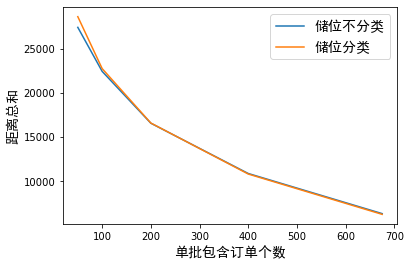

In [271]:
plt.plot([50, 100, 200, 400, 675], [27394., 22419., 16565., 10884.,  6351.], label='储位不分类')
plt.plot([50, 100, 200, 400, 675], [28600., 22734., 16585., 10824.,  6269.], label='储位分类')
plt.xlabel('单批包含订单个数', fontproperties=fontP)
plt.ylabel('距离总和', fontproperties=fontP)
plt.legend(loc='best', prop=fontP)
plt.savefig('images/sensitivity-1.png', bbox_inches='tight')

In [134]:
tuple(curr_pos)

(7, 21)